# A2: MODELING CASE STUDY

### Martha Del Rio || Individual Assignment


The following notebook presents the analysis of a birthweight dataset for newborn babies. Babies who are born with low birthweight can face more health problems than those born at a healthier weight. Doctors and parents want to know which babies might be born too small so they can help prevent this with unborn care. This assignment explores through machine learning models which factors most strongly predict low birthweight and if there is any correlation between the factors. In the end, the aim is to improve birth outcomes by enabling early identification and support for at-risk pregnancies.

<span class="mark">Note: The analysis questions will be answered throughout the script in their respective sections. Markdown cells have been written down to further clarify and explain the thought process for the analysis.</span>

In [1]:
###################
# PACKAGE IMPORTS #
###################

# importing libraries
import numpy             as np                               # mathematical essentials
import pandas            as pd                               # data science essentials
import matplotlib.pyplot as plt                              # data viz
import seaborn           as sns                              # enhanced data viz
import phik 

# model preparation
from sklearn.preprocessing import StandardScaler              # standard scaler
from sklearn.model_selection import train_test_split          # train-test split
from sklearn.model_selection import RandomizedSearchCV        # hp tuning

# model results
from sklearn.metrics import roc_auc_score                     # auc score
from sklearn.metrics import make_scorer                       # customizable scorer
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score

# classification libraries
import sklearn.linear_model                                    # logistic regression
from sklearn.tree     import DecisionTreeClassifier, plot_tree # decision tree
from sklearn.ensemble import RandomForestClassifier            # random forest
from sklearn.ensemble import GradientBoostingClassifier        # gbm

In [2]:
###################
# DATASET IMPORTS #
################### 

# reading modeling data into Python
modeling_data = '/Users/rafaeldelrio/Desktop/kaggle/birthweight.csv'

# creating df_train as the train data
df_train = pd.read_csv(modeling_data, index_col = 'bwt_id')

# reading testing data into Python
testing_data = '/Users/rafaeldelrio/Desktop/kaggle/kaggle_test_data.csv'

# calling this df_test
df_test = pd.read_csv(testing_data, index_col = 'bwt_id')

In [3]:
# concatenating datasets together for mv analysis and feature engineering
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# concatenating both datasets together for mv and feature engineering
df_full = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)


# checking data
df_full.head(n = 5)

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
bwt_id,,,,,,,,,,,,,,,,,,,
bwt_1,28,12.0,2,10.0,31.0,17.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle
bwt_2,21,NaN,1,6.0,21.0,NaN,8.0,9.0,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle
bwt_3,27,15.0,2,11.0,32.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle
bwt_4,33,17.0,1,20.0,39.0,17.0,9.0,10.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle
bwt_5,30,15.0,2,12.0,36.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle


In [4]:
# checking available features
df_full.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps',
       'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck',
       'foth', 'bwght', 'set'],
      dtype='object')

# Exploratory Data Analysis (EDA) and Data Preprocessing (DP)

<span class="birk">Analysis Questions</span>

<span class="birk">1. Are there any strong positive or strong negative linear (Pearson) correlations with birthweight? Answer this question based on the original, continuous form of birthweight. (minimum 5 sentences)</span>

In the EDA, the distribution histograms show that, even with few data points, most of them have a close to normal distribution, even if a little skewed. There are no variables with a Pearson correlation coefficient greater than 0.5 or less than -0.5 with the bwght variable, indicating a lack of strong linear relationships, as visualized in the heatmap. However, this does not cancel the possibility of nonlinear relationships or interactions between variables that could affect bwght. With the histograms, proof is shown that in the case of this dataset, most mothers either didn't smoke or drink, or didn't admit to it. These causes that a vast number of zeroes within the data and rendering it "useless" for the purpose of this analysis, which is to predict low birth in a baby.

In [5]:
##########################
# DESCRIPTIVE STATISTICS #
##########################

# using .describe() to figure out which variables are continuous 
df_full.describe().round(2)

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght
count,473.00,467.00,473.00,452.00,472.00,463.00,471.00,471.00,440.00,441.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,409.00
mean,29.78,13.68,2.21,11.54,32.17,13.87,8.23,8.95,1.17,0.02,0.51,0.87,0.07,0.05,0.88,0.07,0.05,3189.87
std,5.11,2.14,1.33,3.92,6.10,2.22,1.37,0.58,4.21,0.30,0.50,0.34,0.26,0.23,0.33,0.26,0.22,748.45
min,16.00,3.00,0.00,0.00,18.00,6.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00
25%,26.00,12.00,1.00,10.00,28.00,12.00,8.00,9.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,2780.00
50%,30.00,13.00,2.00,12.00,32.00,14.00,9.00,9.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3340.00
75%,33.00,16.00,3.00,13.00,36.00,16.00,9.00,9.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3686.00
max,44.00,17.00,8.00,36.00,62.00,17.00,10.00,10.00,30.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5089.00


<div class="mark">Note: The following histograms were plotted not only to visualize the distribution of data per feature, but also to see if any could be dropped because of a lack of significance, as well as they help brainstorm for the followin missing values imputation and feature engineering.
</div><i class="fa fa-lightbulb-o "></i>

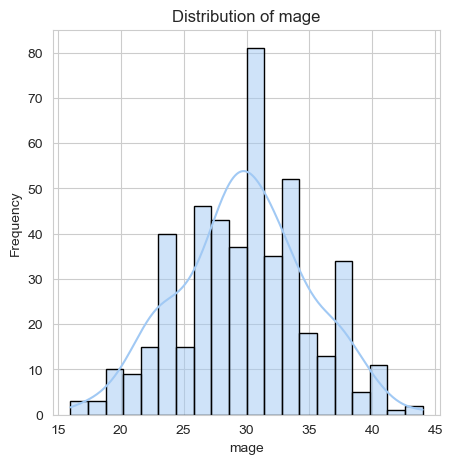

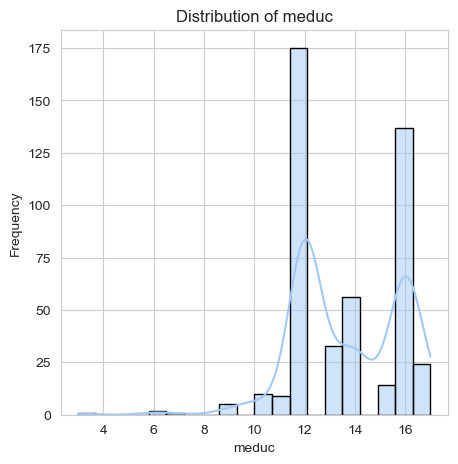

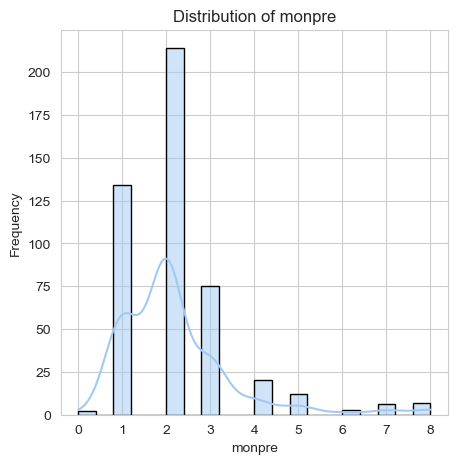

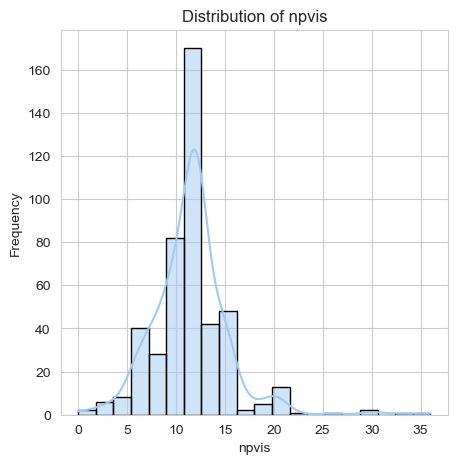

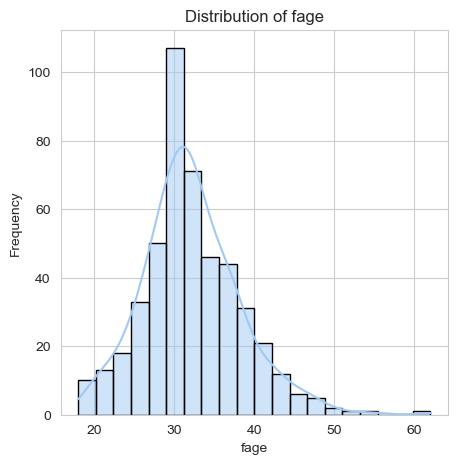

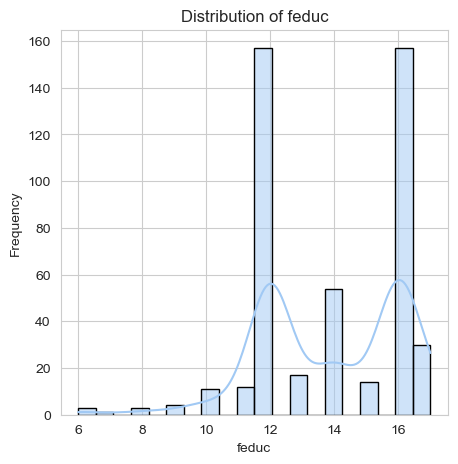

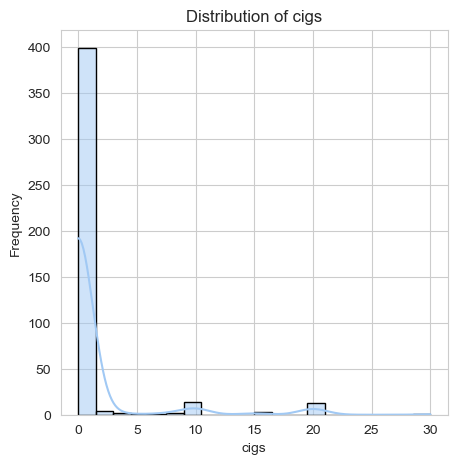

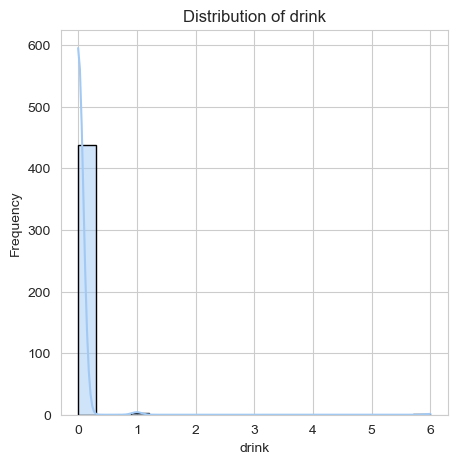

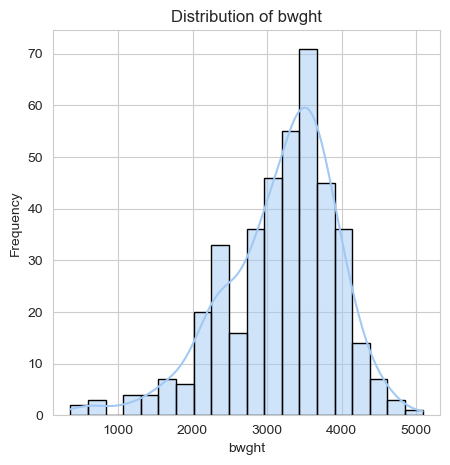

In [6]:
# histogram with distributions of continuous variables
continuous_v = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'bwght']

#setting plot styles
sns.set_style("whitegrid")
sns.set_palette("pastel")

for var in continuous_v:
    plt.figure(figsize=(5, 5))
    sns.histplot(df_full[var], bins=20, edgecolor='black', kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

<div class="mark">Note: The following heatmap shows that the correlations the different features have are not really that strong in regards to 'bwght'. This is proof that there must be a feature that can be engineered to create more relevance between them.
</div><i class="fa fa-lightbulb-o "></i>

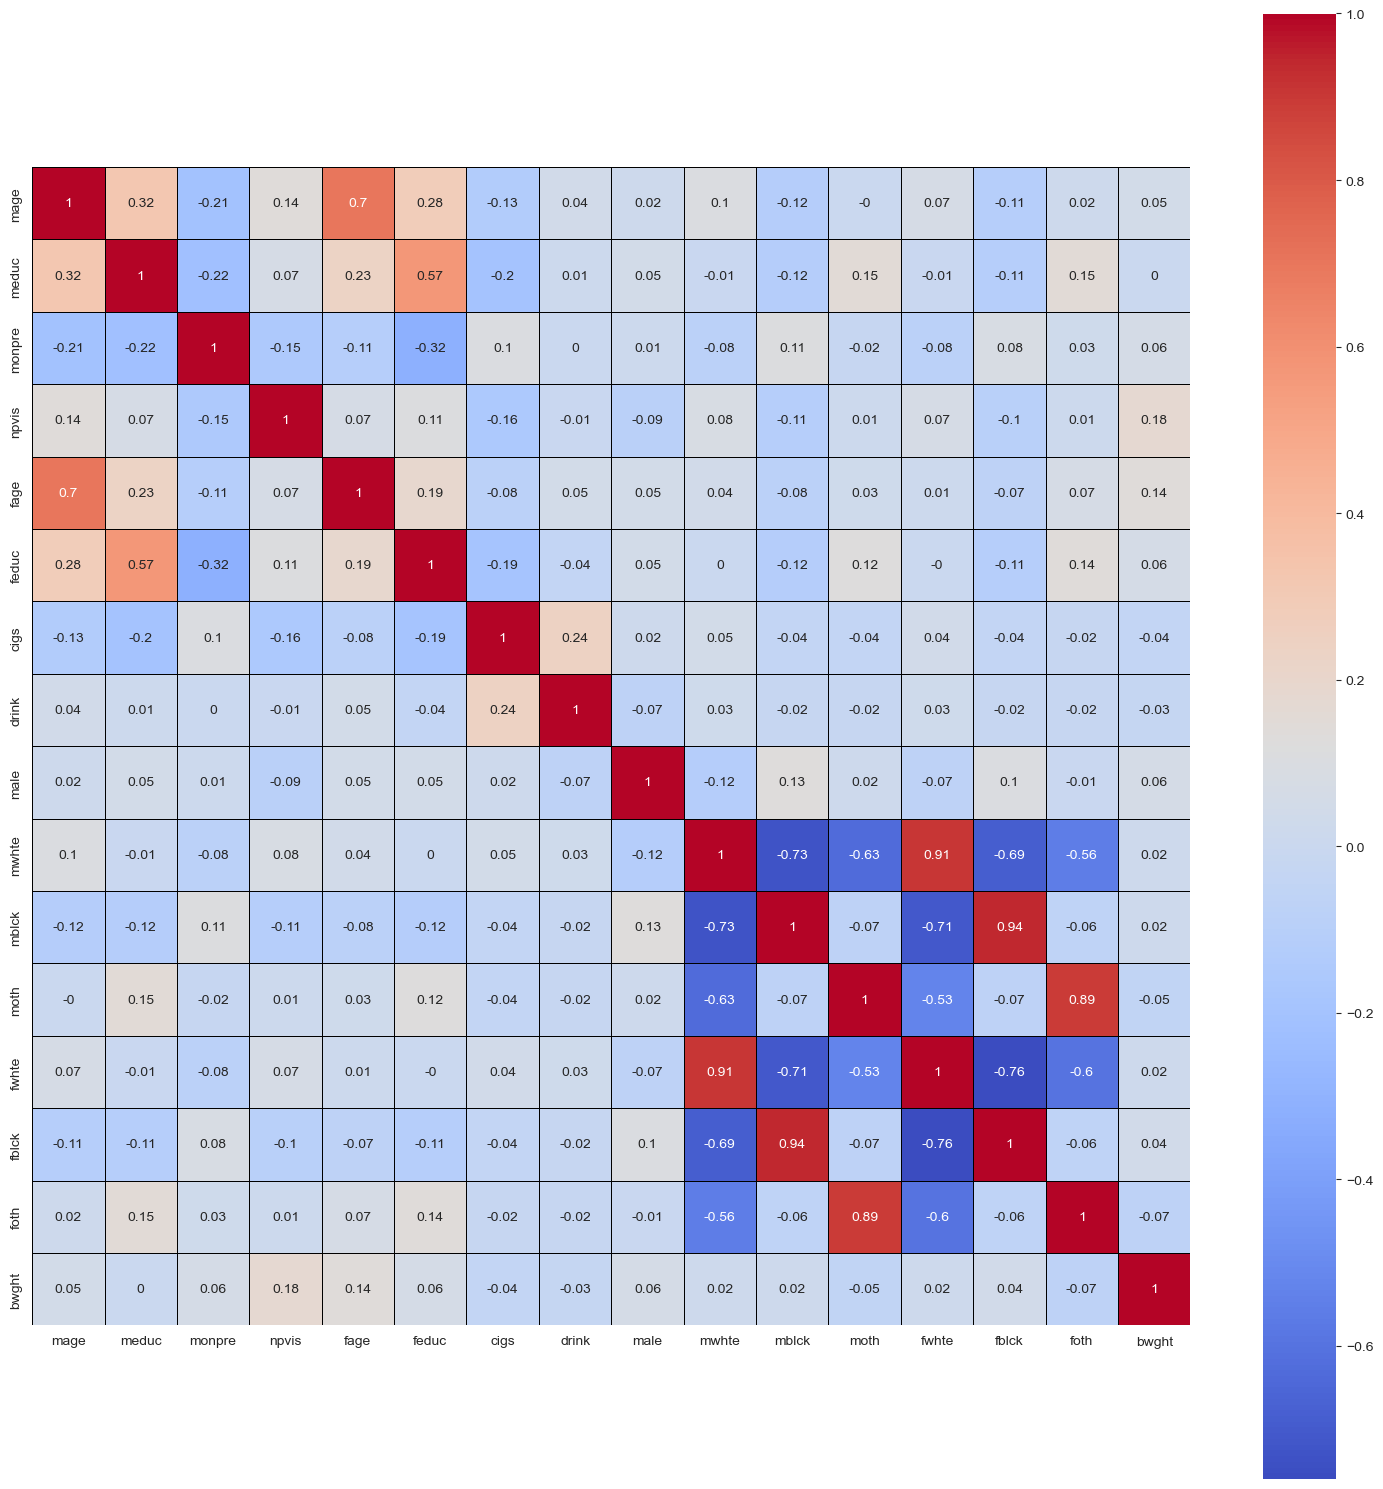

In [7]:
########################
# CORRELATION ANALYSIS #
########################

# instantiating a correlation matrix
df_corr = df_full[['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
                   'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
                   'foth', 'bwght']].corr().round(2)

# setting figure size
fig, ax = plt.subplots(figsize=(15,15))

# visualizing the correlation matrix
sns.heatmap(df_corr,
            cmap = 'coolwarm',
            square = True,
            annot = True,
            linecolor = 'black',
            linewidths = 0.5)

# layout and rendering
plt.tight_layout()
plt.show()

In [8]:
##########################
# MISSING VALUE ANALYSIS #
##########################

# checking for missing values
missing_summary = df_full.isnull().sum()

print(missing_summary)

mage       0
meduc      6
monpre     0
npvis     21
fage       1
feduc     10
omaps      2
fmaps      2
cigs      33
drink     32
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64


<div class="mark">
Note: 'omaps' and 'fmaps' columns are being dropped from the dataset because they are considered to have taken place after the event horizon, as they are tests done to a baby one and fiveminutes after being born, respectively. Also, each value imputation rationale is explained in the comments of the cell.</div><i class="fa fa-lightbulb-o "></i>

In [9]:
############################
# MISSING VALUE IMPUTATION #
############################

# calculating and imputating missing values for the meduc column using mean
# 0 years of education cannot be assume because of their age and the year of the dataset
meduc_mean = df_full['meduc'].mean()
df_full['meduc'].fillna(meduc_mean, inplace = True)

# calculating and imputating missing values for the npvis column using mean
npvis_mean = df_full['npvis'].mean()
df_full['npvis'].fillna(npvis_mean, inplace = True)

#calculating and imputating missing values for the fage column using mean
fage_mean = df_full['fage'].mean()
df_full['fage'].fillna(fage_mean, inplace = True)

# filling missing values with 0
# considering it's only 1 data point, a 0 is imputed to not delete the entire row
df_full['feduc'].fillna(0, inplace = True)

# dropping 'omaps' and 'fmaps' columns because they're event horizons (happen after birth)
df_full.drop(['omaps', 'fmaps'], axis=1, inplace=True)

# replacing missing values with the 0 (few mothers would willingly admit to smoking)
df_full['cigs'].fillna(0, inplace = True)

# replacing missing values with the 0 (few mothers would willingly admit to drinking)
df_full['drink'].fillna(0, inplace = True)


df_full.isna().sum()

mage       0
meduc      0
monpre     0
npvis      0
fage       0
feduc      0
cigs       0
drink      0
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64

# Feature Engineering

<span class="birk">Analysis Questions</span>

<span class="birk">2. Is there an official threshold that signifies when birthweight gets more dangerous? In other words, is there a cutoff point between a healthy birthweight and a non-healthy birthweight? Provide credible sources as necessary. (minimum 5 sentences)</span>

The World Health Organization (WHO) and other important sources (see references) consider as 'low_bwght' below 2,500 grams. Newborns with 'low_bwght' are at a higher risk of health issues and long-term disabilities. Of course not every baby born with 'low_bwght' will for sure have this problems, as other factors in their life and situation contribute to it, but the 2,500-gram threshold is widely used as a benchmark for increased risk. Interestingly enough, babies weighing more than 4,000 grams are often considered to be at risk for birth complications. Both of these can vary depending on other factors such as the mother's health and the baby's length. <span class="mark">Note: for future analysis on this or a similar dataset, it would be insightful to also explore this other side of the threshold.</span>

<span class="birk">3. After transforming birthweight (bwght) using this threshold, did correlations and/or phi coefficients improve? Why or why not? (minimum 5 sentences)</span>

Although the transformation was done on the 'bwght', the highest point-biserial correlation coefficient with 'low_bwght' is with 'npvis', which is negative and quite small in magnitude (-0.1175). Insight 1: This suggests a weak, inverse relationship where more prenatal visits might be associated with a lower incidence of 'low_bwght'. This seems logical as increased prenatal care can often lead to better pregnancy outcomes. Insight 2: Besides this, phi coefficients with 'low_bwght' for the binary variables like race and gender are very low, close to zero, indicating no significant association within this dataset. On the other hand, the rest of the variables seem to have little to no linear association with 'low_bwght' as a binary variable.


#### References (APA)

World Health Organization. (n.d.). Low birth weight. Www.who.int. https://www.who.int/data/nutrition/nlis/info/low-birth-weight#:~:text=Low%20birth%20weight%20has%20been


Low Birth Weight - Health Encyclopedia - University of Rochester Medical Center. (n.d.). www.urmc.rochester.edu. https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=90&contentid=p02382#:~:text=low%20birth%20weight-

March of Dimes. (2021). Low birthweight. www.marchofdimes.org. https://www.marchofdimes.org/find-support/topics/birth/low-birthweight

In [10]:
# threshold found: weight < 2500 grams is catalogued as low birth rate
# using the threshold to categorized bwght into low (1) and not low (0)
df_full['low_bwght'] = (df_full['bwght'] < 2500).astype(int)

In [11]:
##### FEATURE 1.1: parents' age group
# grouping parents by age group, as this might affect the health of a baby and
# the caring decisions they might take for their unborn child
def age_group(age):
    if age <= 29:
        return 1 # '20-29'
    elif age <= 39:
        return 2 # '30-39'
    elif age <= 49:
        return 3 # '40-49'
    else:
        return 4 #'50+'
    
df_full['mage_group'] = df_full['mage'].apply(age_group)
df_full['fage_group'] = df_full['fage'].apply(age_group)

##### FEATURE 1.2: parent's education level
# the decision the parents take could be affected by their combined education level
df_full['parents_educ'] = df_full['meduc'] * df_full['feduc']

In [12]:
##### FEATURE 2: parents' age and baby's gender
# parents age affect the baby's gender and could cause the birth of a healthier
# or not child
df_full['mage_male'] = df_full['mage'] * df_full['male']
df_full['mage_female'] = df_full['mage'] * (1 - df_full['male'])

In [13]:
##### FEATURE 3: unborn care
# assuming lower values indicate earlier and more frequent care the starting 
# month of care by the amount of total care visits the parents had
df_full['unborn_care'] = df_full['monpre'] / df_full['npvis']

# replacing missing values in 'unborn_care' with the calculated mean to ensure
# models can run
unborn_care_mean = df_full['unborn_care'].mean()
df_full['unborn_care'].fillna(value = unborn_care_mean, inplace = True)

In [14]:
# defining original continuous and non-continuous features
continuous_v = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 
                'cigs', 'drink', 'low_bwght', 'mage_group', 'fage_group', 
                'parents_educ', 'mage_male', 'mage_female', 'unborn_care']
non_continuous_v = ['male', 'mwhte', 'mblck', 'moth', 'fwhte','fblck', 
                    'foth', 'low_bwght']


# pearson correlation
corr = df_full[continuous_v].corr(method = 'pearson').round(decimals = 4)


# phi coefficient
phi_corr = df_full[non_continuous_v].phik_matrix(interval_cols = non_continuous_v).round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{corr.loc[ : , 'low_bwght' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{phi_corr.loc[ : , 'low_bwght' ].sort_values(ascending = False)}
""")


Point-Biserial Correlations
---------------------------
low_bwght       1.0000
cigs            0.0495
mage_female     0.0333
meduc           0.0218
unborn_care    -0.0039
parents_educ   -0.0055
mage_group     -0.0101
drink          -0.0103
feduc          -0.0187
mage           -0.0351
mage_male      -0.0448
monpre         -0.0527
fage           -0.0791
fage_group     -0.0907
npvis          -0.1175
Name: low_bwght, dtype: float64


Phi Coefficients
----------------
low_bwght    1.0000
mwhte        0.0181
male         0.0000
mblck        0.0000
moth         0.0000
fwhte        0.0000
fblck        0.0000
foth         0.0000
Name: low_bwght, dtype: float64



# Candidate Modeling Development and Analysis

SELECTED FINAL MODEL: GRADIENT BOOSTING MACHINE MODEL


<span class="birk">Analysis Questions</span>

<span class="birk">4. Which two features in your machine learning model had the largest impact on birthweight? Present one actionable insight for each of these. (minimum 5 sentences per feature)</span>

For this model, it identified 'mage' and 'fage' as the two most important features, besides 'npvis'. This goes back to the correlation analysis that was made, ensuring that the age of the parents might influence the health and weight of a baby when being born (considering as the mother gets older, having a baby comes with more risks, and the father could also encounter problems). 

Insight 1: Since being and older mom is associated with risks including 'low_bwght', there are programs focused on maternal health that give additional resources and education for older expectant woman. For example, targeted nutritional guidance and monitoring for common illnesses could be provided. Mother's, sadly, have to be more careful with themselves if they want to conceive at an older age. The body starts to slowly deteriorate with age, and woman need to be fully aware that their ability will be affected. Constant checkups and planned pregnancies are a great way to counter this. This logically relates to the 'npvis', as prenatal visits are associated with this planning and caring through the process.

Insight 2: On the other hand, the dad's age suggests that factors like hereditary or genetic mutations could impact 'low_bwght'. For example, older fathers can be encourage to engage in preconception health checks and consider lifestyle changes that help get healthier sperm. Just like with mother's, although father's can still have healthy sperm even when older, most men have to be educated to take care of themselves to be able to be healthy. Also, 'low_bwght' can be a consequence of bad handling of this. Father's should strive to help have a healthy baby with no problems if possible.

<span class="birk">5. Present your final model's confusion matrix and explain what each error means (false positives and false negatives). Furthermore, explain which error is being controlled for given the cohort's focus on correctly predicting low birthweight, as well as why this error is more important to control than the other error. (minimum 5 sentences)</span>

Considering the following confusion matrix for the Gradient Boosting Machines model (the selected one as final and at the very end of this notebook):


(TN) True Negatives : 71 -> model correctly identified normal birthweight, important for avoiding unnecessary interventions.

(FP) False Positives: 12 -> model incorrectly predicted low birthweight, and this type of error might lead to unnecessary medical interventions and increasing costs, but better safe than sorry.

(FN) False Negatives: 18 -> MODEL FAILED TO IDENTIFY LOW BIRTHWEIGHT, which is the most significant error as it can lead to children missing out on essential care critical for their health.

(TP) True Positives : 2 -> model correctly identified low birthweight, crucial for providing timely and appropriate healthcare interventions.


Definitely, controlling for false negatives is the most important. This is because the consequences of not identifying a baby as low birthweight can be far more severe than identifying a baby as low birthweight when they are not. The former could lead to no necessary medical support and interventions, possibly resulting in poor health. Therefore, in this context it's generally more important to ensure all at-risk babies are identified, even if there's some over-classification. Also, the model results in the matrix indicates a strong focus on avoiding false positives. With 83 true negatives and 12 false positives, it shows that the model is very conservative in predicting low birthweight. This being said, the GBM model could be better at correctly identifying cases of low birthweight, as portrayed by its recall and AUC values, which is crucial for ensuring appropriate medical intervention on time.

Unlike other model's, this one was not the highest score on Kaggle (having a better score for the logistic regression one). Regardless of this, the GBM model is better in this case at predicting 'low_bwght' because it has less false negatives that, as stated before, is a significant error that must be controlled. In the end, the smaller the number for FN the fewer cases of low birthweight go undetected.


#### References (APA)

Neurological Health Foundation (NHF) - Unlock Your Child’s Potential. (n.d.). Neurological Health Foundation (NHF). Retrieved April 5, 2024, from https://neurologicalhealth.org/?gad_source=1&gclid=CjwKCAjwwr6wBhBcEiwAfMEQsygst6MY165uAN5jCuu1ANyNz4Yyw8T1Ht56G_6vHo7XZGvGKlJ90RoClNgQAvD_BwE


In [15]:
# creating a function to standardize data

def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [16]:
###################
# DATA SEPARATION #
###################

# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True,
                )


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

df.head()

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,...,fblck,foth,bwght,low_bwght,mage_group,fage_group,parents_educ,mage_male,mage_female,unborn_care
bwt_id,,,,,,,,,,,,,,,,,,,,,
bwt_1,28,12.000000,2,10.0,31.0,17.0,0.0,0.0,0,1,...,0,0,3317.0,0,1,2,204.0,0,28,0.200000
bwt_2,21,13.680942,1,6.0,21.0,0.0,0.0,0.0,0,1,...,0,0,1160.0,1,1,1,0.0,0,21,0.166667
bwt_3,27,15.000000,2,11.0,32.0,16.0,0.0,0.0,1,1,...,0,0,4706.0,0,1,2,240.0,27,0,0.181818
bwt_4,33,17.000000,1,20.0,39.0,17.0,0.0,0.0,0,0,...,0,1,3289.0,0,2,2,289.0,0,33,0.050000
bwt_5,30,15.000000,2,12.0,36.0,16.0,0.0,0.0,1,1,...,0,0,3490.0,0,2,2,240.0,30,0,0.166667


In [17]:
# declaring explanatory variables
bw_data   = df[['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
                'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
                'foth','mage_group', 'fage_group', 'parents_educ', 'mage_male', 
                'mage_female']]

# declaring response variable
bw_target = df['low_bwght']

In [18]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
    bw_data,
    bw_target,
    test_size    = 0.25,
    random_state = 702,
    stratify     = bw_target  # Make sure to pass stratify as an argument to train_test_split
)

# merging training data for statsmodels
bw_train = pd.concat([x_train, y_train], axis = 1)

In [19]:
############################
# RANDOM FOREST CLASSIFIER #
############################

In [20]:
# INSTANTIATING a random forest model with default hyperparameters
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 702)

In [21]:
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', round(rf_default_fit.score(x_train, y_train), ndigits = 4))
print('Testing  ACCURACY:', round(rf_default_fit.score(x_test , y_test ), ndigits = 4))



# saving AUC score
print('AUC Score        :', round(roc_auc_score(y_true  = y_test,
                                                y_score = rf_default_fit_pred), ndigits = 4))

Training ACCURACY: 0.9118
Testing  ACCURACY: 0.7961
AUC Score        : 0.5319


In [22]:
# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")


True Negatives : 80
False Positives: 3
False Negatives: 18
True Positives : 2



In [23]:
# instantiating a hyperparameter space
estimator_range  = np.arange(50, 100, 1000)
leaf_range       = np.arange(1, 31, 10)
criterion_range  = ['gini', 'entropy']
bootstrap_range  = [True, False]
warm_start_range = [True, False]
max_depth        = np.arange(1, 21, 1)


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_range,
              'min_samples_leaf' : leaf_range,
              'criterion'        : criterion_range,
              'bootstrap'        : bootstrap_range,
              'warm_start'       : warm_start_range}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 702)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 5,
                               n_iter     = 700,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(bw_data, bw_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(decimals = 4))

/Users/rafaeldelrio/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=700. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned Parameters  : {'warm_start': True, 'n_estimators': 50, 'min_samples_leaf': 1, 'criterion': 'entropy', 'bootstrap': True}
Tuned Training AUC: 0.5007


In [24]:
## building a model based on hyperparameter tuning results

# INSTANTIATING with best_estimator
forest_tuned = RandomForestClassifier(criterion        = 'entropy', 
                                      min_samples_leaf = 1,
                                      n_estimators     = 50, 
                                      random_state     = 702, 
                                      warm_start       = True)



# FITTING to the FULL DATASET (due to cross-validation)
forest_tuned_fit = forest_tuned.fit(bw_data, bw_target)


# PREDICTING on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)



# saving scoring data for future use
forest_tuned_train_score = round(forest_tuned.score(x_train, y_train),
                                 ndigits = 4)

forest_tuned_test_score  = round(forest_tuned.score(x_test, y_test),
                                 ndigits = 4)


# saving the AUC score
forest_tuned_auc = round(roc_auc_score(y_true  = y_test,
                                       y_score = forest_tuned_pred),
                                       ndigits = 4)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned_train_score)
print('Forest Tuned Testing  ACCURACY:', forest_tuned_test_score)
print('Forest Tuned AUC Score        :', forest_tuned_auc)

Forest Tuned Training ACCURACY: 0.9967
Forest Tuned Testing  ACCURACY: 0.9903
Forest Tuned AUC Score        : 0.975


In [25]:
# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test,
                               y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")


True Negatives : 83
False Positives: 0
False Negatives: 1
True Positives : 19



In [26]:
##############################
# KAGGLE SUBMISSION (FOREST) #
##############################

x_features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
              'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
              'foth','mage_group', 'fage_group', 'parents_educ', 'mage_male', 
              'mage_female']

y_target = 'low_bwght'

# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# y-data
y_data_kaggle = kaggle_data[y_target]

# Fitting model from above to the Kaggle test data
kaggle_predictions = forest_cv.predict(x_data_kaggle)

# organizing predictions
model_predictions = {"low_bwght" : kaggle_predictions}


# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)

# name your model
model_pred_df.to_csv(path_or_buf = "/Users/rafaeldelrio/Desktop/kaggle/model_output/test1.csv",
                     index       = True,
                     index_label = 'bwt_id')

In [27]:
# standardizing the x-features
x_data_st = standard_scaler(df = bw_data )


# checking results
x_data_st.head()

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,mage_group,fage_group,parents_educ,mage_male,mage_female
0,-0.361492,-0.773509,-0.165141,-0.411688,-0.202607,1.148583,-0.269856,-0.071442,-0.978232,0.381652,-0.281346,-0.238427,0.377436,-0.281346,-0.232645,-1.018597,0.298341,0.261394,-0.952922,0.831007
1,-1.728666,0.011534,-0.915613,-1.464664,-1.836508,-4.646843,-0.269856,-0.071442,-0.978232,0.381652,-0.281346,-0.238427,0.377436,-0.281346,-0.232645,-1.018597,-1.266036,-3.247546,-0.952922,0.375489
2,-0.556802,0.627567,-0.165141,-0.148445,-0.039217,0.807676,-0.269856,-0.071442,1.022252,0.381652,-0.281346,-0.238427,0.377436,-0.281346,-0.232645,-1.018597,0.298341,0.880619,0.806797,-0.991067
3,0.615061,1.561617,-0.915613,2.220750,1.104513,1.148583,-0.269856,-0.071442,-0.978232,-2.620188,-0.281346,4.194152,-2.649454,-0.281346,4.298394,0.792734,0.298341,1.723453,-0.952922,1.156378
4,0.029129,0.627567,-0.165141,0.114799,0.614343,0.807676,-0.269856,-0.071442,1.022252,0.381652,-0.281346,-0.238427,0.377436,-0.281346,-0.232645,0.792734,0.298341,0.880619,1.002321,-0.991067


In [28]:
#######################
# LOGISTIC REGRESSION #
#######################

In [29]:
# train/test split with standardized x-features
x_scaled =  x_data_st
y_scaled =  df['low_bwght']


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            x_scaled,
            y_scaled,
            random_state = 702,
            test_size    = 0.25,
            stratify     = y_scaled)

# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver = 'lbfgs',
                                                 C = 1,
                                                 random_state = 702)


# FITTING the training data
logreg_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# saving scoring data for future use
train_score = round(logreg_fit.score(x_train, y_train), ndigits = 4) # train accuracy
test_score  = round(logreg_fit.score(x_test, y_test),   ndigits = 4) # test accuracy
tt_gap      = round(abs(train_score - test_score),      ndigits = 4) # gap

# displaying and saving the gap between training and testing
print(f"""\
Training ACCURACY: {train_score}
Testing  ACCURACY: {test_score}
Train-Test Gap   : {tt_gap}
""") 
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")
# preparing AUC, precision, and recall
auc       = round(roc_auc_score(y_true = y_test, y_score = logreg_pred) , ndigits = 4)
precision = round(precision_score(y_true = y_test, y_pred = logreg_pred), ndigits = 4)
recall    = round(recall_score(y_true = y_test, y_pred = logreg_pred)   , ndigits = 4)


# dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

Training ACCURACY: 0.8137
Testing  ACCURACY: 0.8155
Train-Test Gap   : 0.0018


True Negatives : 83
False Positives: 0
False Negatives: 19
True Positives : 1

AUC:       0.525
Precision: 1.0
Recall:    0.05



In [30]:
################################
# KAGGLE SUBMISSION (LOGISTIC) #
################################

x_features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
              'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
              'foth','mage_group', 'fage_group', 'parents_educ', 'mage_male', 
              'mage_female']

y_target = 'low_bwght'

# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# y-data
y_data_kaggle = kaggle_data[y_target]

# Fitting model from above to the Kaggle test data
kaggle_predictions = logreg_fit.predict(x_data_kaggle)

# organizing predictions
model_predictions = {"low_bwght" : kaggle_predictions}


# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)

# name your model
model_pred_df.to_csv(path_or_buf = "/Users/rafaeldelrio/Desktop/kaggle/model_output/logreg.csv",
                     index       = True,
                     index_label = 'bwt_id')

In [31]:
################################         ##########################
# GRADIENT BOOSTING CLASSIFIER #         #  F I N A L  M O D E L  #
################################         ##########################

Note: This model presented severe overfitting when tuning the hyperparameters, which could be because of it learning the noise in the training data instead of the pattern. Also, there could've been an insufficient cross-validation, as there could be not enough folds or inappropriate splitting of data. A more complex model isn't always better, simpler models with fewer parameters can generalize better to new data. And this is why the untuned model was used and submitted.

In [32]:
# train/test split with standardized x-features
x_data  =  df[['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink',
                'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 
                'mage_group', 'fage_group', 'parents_educ', 'mage_male',
                'mage_female']]
y_data =  df['low_bwght']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            x_data,
            y_data,
            random_state = 702,
            test_size    = 0.25,
            stratify     = y_data)

In [33]:
# INSTANTIATING the model object without hyperparameters
full_gbm_def = GradientBoostingClassifier(loss = 'log_loss',
                                          learning_rate = 0.1,
                                          n_estimators  = 100,
                                          criterion     = 'friedman_mse',
                                          max_depth     = 3,
                                          warm_start    = False,
                                          random_state  = 702)


# FITTING to the training data
full_gbm_def_fit = full_gbm_def.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_def_pred = full_gbm_def_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', round(full_gbm_def_fit.score(x_train, y_train),
                                  ndigits = 4))
      
print('Testing ACCURACY :', round(full_gbm_def_fit.score(x_test, y_test),
                                  ndigits = 4))
      
print('AUC Score        :', round(roc_auc_score(y_true  = y_test,
                                                y_score = full_gbm_def_pred),
                                  ndigits = 4))
# preparing AUC, precision, and recall
precision = round(precision_score(y_true = y_test, y_pred = full_gbm_def_pred), ndigits = 4)
recall    = round(recall_score(y_true = y_test, y_pred = full_gbm_def_pred)   , ndigits = 4)


# dynamically printing metrics
print(f"""\
Precision: {precision}
Recall:    {recall}
""")

# unpacking the confusion matrix
gbm_def_tn, \
gbm_def_fp, \
gbm_def_fn, \
gbm_def_tp = confusion_matrix(y_true = y_test, 
                              y_pred = full_gbm_def_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_def_tn}
False Positives: {gbm_def_fp}
False Negatives: {gbm_def_fn}
True Positives : {gbm_def_tp}
""")

Training ACCURACY: 0.9216
Testing ACCURACY : 0.7087
AUC Score        : 0.4777
Precision: 0.1429
Recall:    0.1


True Negatives : 71
False Positives: 12
False Negatives: 18
True Positives : 2



<span class="mark">Note: From this visualization the features with the most impact are, besides the number of prenatal visits, the ages of both parents. This makes sense as they directly impacted how healthy a baby can be because of the complications that being older brings to the table.</span>

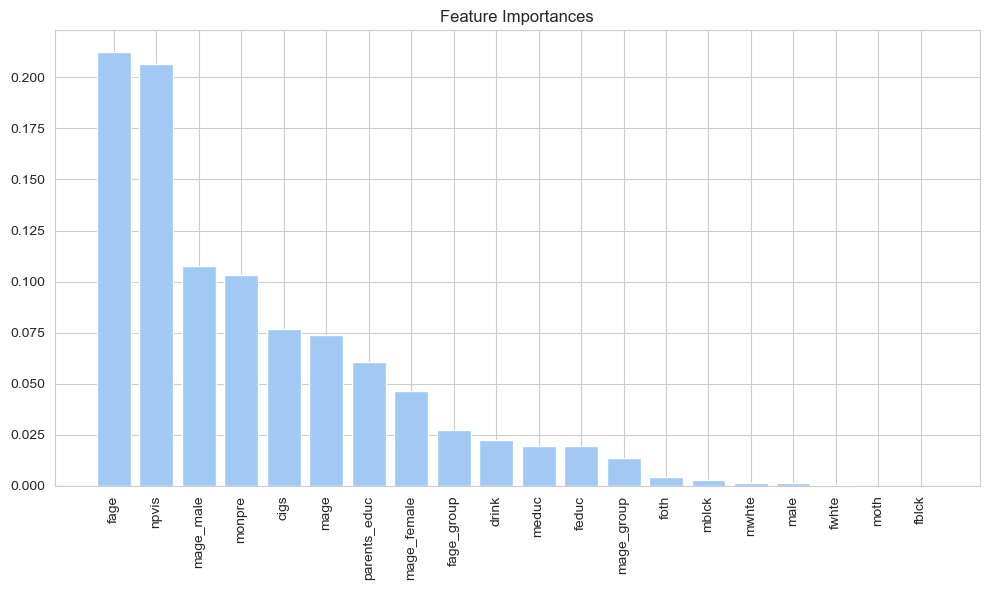

In [34]:
# Get the importance of x features with .feature_importances_ in the model
feature_importances = full_gbm_def_fit.feature_importances_

# Get the feature names
features = x_train.columns

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting the bar graph
plt.figure(figsize = (10, 6))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align = "center")
plt.xticks(range(x_train.shape[1]), features[sorted_indices], rotation = 90)
plt.tight_layout()
plt.show()

In [36]:
################################
# KAGGLE SUBMISSION (GRADIENT) #
################################

x_features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 
              'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 
              'foth','mage_group', 'fage_group', 'parents_educ', 'mage_male', 
              'mage_female']

y_target = 'low_bwght'

# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# y-data
y_data_kaggle = kaggle_data[y_target]

# Fitting model from above to the Kaggle test data
kaggle_predictions = full_gbm_def_fit.predict(x_data_kaggle)

# organizing predictions
model_predictions = {"low_bwght" : kaggle_predictions}


# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)

# name your model
model_pred_df.to_csv(path_or_buf = "/Users/rafaeldelrio/Desktop/kaggle/model_output/GMB_tuned.csv",
                     index       = True,
                     index_label = 'bwt_id')